# Data-structure of graphs in neural-lam

*16/4/2024, Leif Denby (lcd@dmi.dk)*

This notebook is a brief overview of the data-structure used to represent graphs in the neural-lam model, showing how data is stored on disk and how to load the graph. Internally in neural-lam there two sets of nodes:

1. grid nodes: the physical space where node features are the physical variables
2. mesh nodes: the nodes onto which the physical variables are projected (*encoded*), on which the processing network operates (to predict the next atmospheric state) and finally the output is projected back (*decoded*) to the grid nodes.

All nodes are represented in a single graph, with separate sets of edges for each of the three encoding, processing and decoding steps. In addition, there may optionally be multiple layers to the processing network, and so the edges there a further subdivided into layers (represented by a list of edge lists).

In [10]:
import torch_geometric as pyg
import torch
import networkx
import numpy as np
import matplotlib.pyplot as plt
from pysankey import sankey

from pathlib import Path

In [29]:
fp_root = Path().resolve().parent / "data"
list(fp_root.glob("*")) 

[PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/1level'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/multiscale')]

In [40]:
fp = fp_root / "hierarchical"
list(fp.glob("*")) 

[PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical/g2m_edge_index.pt'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical/g2m_features.pt'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical/m2g_edge_index.pt'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical/m2g_features.pt'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical/m2m_edge_index.pt'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical/m2m_features.pt'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical/mesh_down_edge_index.pt'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical/mesh_down_features.pt'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical/mesh_features.pt'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hierarchical/mesh_up_edge_index.pt'),
 PosixPath('/home/leif/git-repos/dmi/mllam/neural-lam/data/hier

In [41]:
g2m_edge_index = torch.load(fp / "g2m_edge_index.pt")
m2g_edge_index = torch.load(fp / "m2g_edge_index.pt")
m2m_edge_index = torch.load(fp / "m2m_edge_index.pt")

In [42]:
g2m_edge_index.shape, m2g_edge_index.shape

(torch.Size([2, 100656]), torch.Size([2, 255136]))

In [43]:
m2m_edge_index

[tensor([[   0,    0,    0,  ..., 6560, 6560, 6560],
         [  81,    1,   82,  ..., 6479, 6559, 6478]]),
 tensor([[6561, 6561, 6561,  ..., 7289, 7289, 7289],
         [6588, 6562, 6589,  ..., 7262, 7288, 7261]]),
 tensor([[7290, 7290, 7290,  ..., 7370, 7370, 7370],
         [7299, 7291, 7300,  ..., 7361, 7369, 7360]]),
 tensor([[7371, 7371, 7371, 7372, 7372, 7372, 7372, 7372, 7373, 7373, 7373, 7374,
          7374, 7374, 7374, 7374, 7375, 7375, 7375, 7375, 7375, 7375, 7375, 7375,
          7376, 7376, 7376, 7376, 7376, 7377, 7377, 7377, 7378, 7378, 7378, 7378,
          7378, 7379, 7379, 7379],
         [7374, 7372, 7375, 7375, 7371, 7373, 7376, 7374, 7376, 7372, 7375, 7371,
          7377, 7375, 7378, 7372, 7372, 7378, 7374, 7376, 7371, 7379, 7373, 7377,
          7373, 7379, 7375, 7372, 7378, 7374, 7378, 7375, 7375, 7377, 7379, 7374,
          7376, 7376, 7378, 7375]])]

In [44]:
g2m_edge_index.shape

torch.Size([2, 100656])

In [45]:
g2m_pyg = pyg.data.Data(edge_index=g2m_edge_index)

In [46]:
g2m_nx = pyg.utils.to_networkx(g2m_pyg)

/home/leif/miniconda3/envs/neural-lam/lib/python3.10/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [47]:
np.unique(m2g_edge_index[0].numpy())
np.unique(g2m_edge_index[0].numpy())
np.unique(m2m_edge_index[0].numpy())

array([   0,    1,    2, ..., 6558, 6559, 6560])

Text(0.5, 0, 'graph node id')

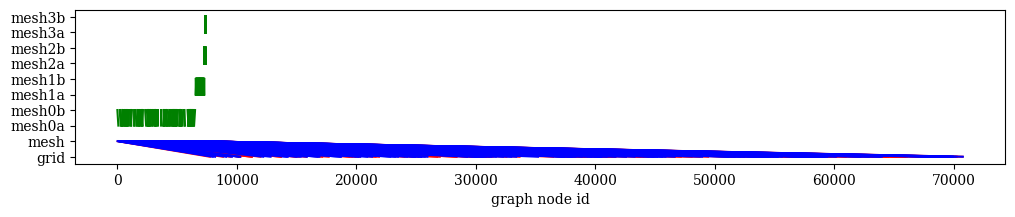

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

_, n_m2g = m2g_edge_index.shape
_, n_g2m = g2m_edge_index.shape
n_lines = 100

for i in np.random.choice(range(n_g2m), n_lines):
    ax.plot(g2m_edge_index.numpy()[:,i], ["grid", "mesh"], label="g2m", color="red")

for i in np.random.choice(range(n_m2g), n_lines):
    ax.plot(m2g_edge_index.numpy()[:,i], ["mesh", "grid"], label="m2g", color="blue")
    
for j in range(len(m2m_edge_index)):
    _, n = m2m_edge_index[j].shape
    for i in np.random.choice(range(n), n_lines):
        ax.plot(m2m_edge_index[j].numpy()[:,i], [f"mesh{j}a", f"mesh{j}b"], label="m2m", color="green")
ax.set_xlabel("graph node id")

## Visualisation of node IDs and edge connections for different kinds of processing graphs

We can combine the steps above into a single function so that we can plot the full connection graph for each.

In [87]:
def plot_edges_and_nodes(fp_graph_root, n_lines=100, ax=None):
    g2m_edge_index = torch.load(fp_graph_root / "g2m_edge_index.pt")
    m2g_edge_index = torch.load(fp_graph_root / "m2g_edge_index.pt")
    m2m_edge_index = torch.load(fp_graph_root / "m2m_edge_index.pt")

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 2))

    _, n_m2g = m2g_edge_index.shape
    _, n_g2m = g2m_edge_index.shape
    
    legn_lines = []

    for s, i in enumerate(np.random.choice(range(n_g2m), n_lines)):
        lines = ax.plot(g2m_edge_index.numpy()[:,i], ["grid", "mesh"], label="g2m", color="red")
        if s == 0:
            legn_lines.append(lines[0])

    for s, i in enumerate(np.random.choice(range(n_m2g), n_lines)):
        lines = ax.plot(m2g_edge_index.numpy()[:,i], ["mesh", "grid"], label="m2g", color="blue")
        if s == 0:
            legn_lines.append(lines[0])
        
    for j in range(len(m2m_edge_index)):
        _, n = m2m_edge_index[j].shape
        for s, i in enumerate(np.random.choice(range(n), n_lines)):
            lines = ax.plot(m2m_edge_index[j].numpy()[:,i], [f"mesh{j}a", f"mesh{j}b"], label=f"m2m ({j})", color="green")
            if s == 0:
                legn_lines.append(lines[0])
    ax.set_xlabel("graph node id")
    ax.legend(legn_lines, [l.get_label() for l in legn_lines], loc="upper right")
    
    return ax

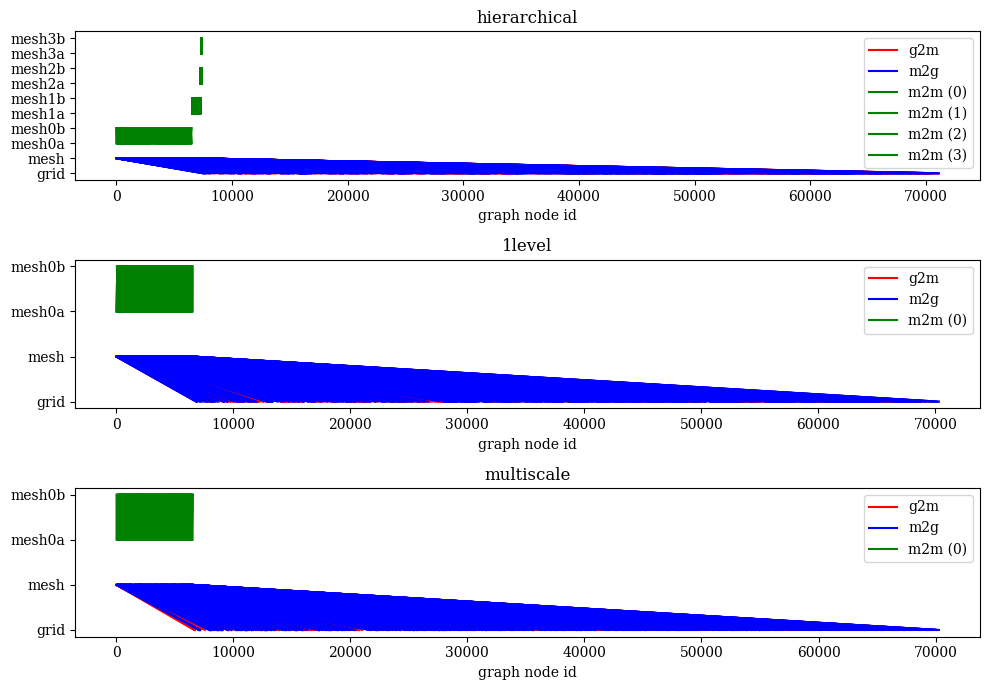

In [93]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 7))
fp_root = Path().resolve().parent / "data"
fp = fp_root / "hierarchical"
for ax, graph_kind in zip(axes, ["hierarchical", "1level", "multiscale"]):
    ax = plot_edges_and_nodes(fp_root / graph_kind, ax=ax, n_lines=400)
    ax.set_title(graph_kind)
    
fig.tight_layout()

From these plots we can see that:

- all nodes are stored in a single graph
- the mesh nodes come first in the graph in terms of node index, followed by the grid nodes
- when using a hierarchical graph all the mesh nodes of the full hierarchy come before the mesh nodes
- for the test MEPS data that Joel has provided me there are an order of magnitude mode grid nodes than mesh nodes